In [1]:
import os
import random
import sys
from contextlib import contextmanager
from glob import glob
from time import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from category_encoders.target_encoder import TargetEncoder
from gensim.models import word2vec, KeyedVectors
from tqdm import tqdm
tqdm.pandas()

import xfeat

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def fit_lgbm_regressor(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgbm.LGBMRegressor(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            model.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=verbose, 
                eval_metric='rmse',
                verbose=verbose)

        pred_i = model.predict(x_valid)
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))

    return oof_pred, models

def fit_lgbm_classifier(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgbm.LGBMClassifier(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            model.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=verbose, 
                eval_metric='logloss',
                verbose=verbose)

        pred_i = model.predict_proba(x_valid)[:,1]
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} logloss: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))

    return oof_pred, models

def create_predict_lgbm_regressor(models, feat_df):
    pred = np.array([model.predict(feat_df.values) for model in models])
    pred = np.mean(pred, axis=0)

    return pred

def create_predict_lgbm_classifier(models, feat_df):
    pred = np.array([model.predict_proba(feat_df.values)[:,1] for model in models])
    pred = np.mean(pred, axis=0)

    return pred

def run_lgbm_regressor(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_lgbm_regressor(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_lgbm_regressor(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

def run_lgbm_classifier(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_lgbm_classifier(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_lgbm_classifier(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()

    return feature_importance_df

In [3]:
data_dir = Path('../../data')
train = pd.read_csv(data_dir.joinpath('train.csv'))
test = pd.read_csv(data_dir.joinpath('test.csv'))
sub = pd.read_csv(data_dir.joinpath('atmacup10__sample_submission.csv'))

color_df = pd.read_csv(data_dir.joinpath('color.csv'))
historical_person_df = pd.read_csv(data_dir.joinpath('historical_person.csv'))
maker_df = pd.read_csv(data_dir.joinpath('maker.csv'))
material_df = pd.read_csv(data_dir.joinpath('material.csv'))
object_collection_df = pd.read_csv(data_dir.joinpath('object_collection.csv'))
palette_df = pd.read_csv(data_dir.joinpath('palette.csv'))
principal_maker_df = pd.read_csv(data_dir.joinpath('principal_maker.csv'))
principal_maker_occupatio_df = pd.read_csv(data_dir.joinpath('principal_maker_occupation.csv'))
production_place_df = pd.read_csv(data_dir.joinpath('production_place.csv'))
technique_df = pd.read_csv(data_dir.joinpath('technique.csv'))

In [4]:
def get_subtitle(df: pd.DataFrame):
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        df[column_name] = size_info[column_name]
    
    df['size_hw'] = df['size_h'] * df['size_w']
    df['size_hwd'] = df['size_h'] * df['size_w'] * df['size_d']
    
    
    return df

train = get_subtitle(train)
test = get_subtitle(test)

material_df['count'] = material_df['name'].map(material_df['name'].value_counts())
_df = material_df.sort_values(
    ['object_id', 'count'], ascending=True
    ).groupby('object_id').first().rename(columns={'name': 'material_cat'})
train = train.merge(_df[['material_cat']], on='object_id', how='left')
test = test.merge(_df[['material_cat']], on='object_id', how='left')

In [5]:
def proceccing_size(train: pd.DataFrame, test:pd.DataFrame):
    df = pd.concat([train, test]).reset_index(drop=True)
    aggregated_df, aggregated_cols = xfeat.aggregation(
        df,
        group_key='principal_maker',
        group_values=['size_w', 'size_h', 'size_t', 'size_d', 'size_hw', 'size_hwd'],
        agg_methods=['mean', 'min', 'max', 'std'],
        )

    aggregated_df = aggregated_df[aggregated_cols].copy()
    for col in ['size_w', 'size_h', 'size_t', 'size_d', 'size_hw', 'size_hwd']:
        aggregated_df[f'diff_agg_mean_{col}_grpby_principal_maker'] = aggregated_df[f'agg_mean_{col}_grpby_principal_maker'] - train[col]
 
    return aggregated_df[:len(train)], aggregated_df[len(train):].reset_index(drop=True)

feature_list = [
    'artseriesid_count_basefeature',
    'title_tfidf',
    'title_basefeature',
    'title_label_basefeature',
    'title_count_basefeature',
    'description_tfidf',
    'description_basefeature',
    'description_label_basefeature',
    'description_count_basefeature',
    'longtitle_tfidf',
    'longtitle_basefeature',
    'longtitle_label_basefeature',
    'longtitle_count_basefeature',
    'principalmaker_label_basefeature',
    'principalmaker_count_basefeature',
    'principalorfirstmaker_label_basefeature',
    'principalorfirstmaker_count_basefeature',
    'subtitle_basefeature',
    'copyrightholder_label_basefeature',
    'copyrightholder_count_basefeature',
    'moretitle_tfidf',
    'moretitle_basefeature',
    'moretitle_label_basefeature',
    'moretitle_count_basefeature',
    'acquisitionmethod_label_basefeature',
    'acquisitionmethod_count_basefeature',
    'acquisitiondate_basefeature',
    'acquisitioncreditline_label_basefeature',
    'acquisitioncreditline_count_basefeature',
    'datingdate_basefeature',
    'material_basefeature',
    'object_collection_basefeature',
    'historicalperson_basefeature',
    'productionplace_basefeature',
    'technique_basefeature',
    'placeofbirth_label_basefeature',
    'placeofbirth_count_basefeature',
    'placeofdeath_label_basefeature',
    'placeofdeath_count_basefeature',
    'datebirthdeath_basefeature',
    'makername_basefeature',
    'qualification_basefeature',
    'roles_basefeature',
    'production_placesfeature',
    'color2vec_dimension_deletionfeature',
    'bert_dimension_deletionfeature',
    'targetencoding_materialfeature',
    'targetencoding_objectcollectionfeature',
    'targetencoding_techniquefeature',
    'targetencoding_dating_periodfeature'
]


features_dir = Path('../../features/colum2131/model1')

train_features = []
test_features = []

for col in ['title', 'long_title', 'more_title', 'description', 'acquisition_credit_line']:
    train_tmp = pd.read_pickle(f'../../features/colum2131/Universal_feature/train/{col}.pickle')
    test_tmp = pd.read_pickle(f'../../features/colum2131/Universal_feature/test/{col}.pickle')
    _df = pd.concat([train_tmp, test_tmp]).reset_index(drop=True)
    pca = PCA(n_components=10, random_state=42)
    features = pd.DataFrame(pca.fit_transform(_df), columns=[f'universalencoder_{col}_pca_{i}' for i in range(10)])
    
    train_features.append(features[:len(train)])
    test_features.append(features[len(train):].reset_index(drop=True)) 

for feature_name in feature_list:
    train_features.append(pd.read_feather(features_dir.joinpath(f'{feature_name}_train.ftr')))
    test_features.append(pd.read_feather(features_dir.joinpath(f'{feature_name}_test.ftr')))
    
train_X = pd.concat(train_features, axis=1)
test_X = pd.concat(test_features, axis=1)
train_y = np.log1p(train['likes'])

In [6]:
ensumble_dir = Path('../../ensemble/colum2131_data')

params = {
 'subsample': 1.0,
 'reg_alpha': 1.0,
 'reg_lambda': 1.0, 
 'metric': 'rmse',
 'min_child_samples': 20,
 'num_leaves': 31,
 'n_estimators': 100000,
 'objective': 'regression',
 'learning_rate': 0.01,
 'random_state': 42
 }

oof_lgbm = np.zeros(train_X.shape[0])
prediction_lgbm = np.zeros(test_X.shape[0])

SEEDS = [12] # np.arange(0, 10, 1)
for seed in SEEDS:
    params['random_state'] = seed
    oof_pred, prediction, models_lgbm, cv = run_lgbm_regressor(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=params,
        verbose=100,
        seed=seed)
    print(cv)

    oof_lgbm += oof_pred / len(SEEDS)
    prediction_lgbm += prediction / len(SEEDS)

cv = np.sqrt(mean_squared_error(train_y, np.where(oof_lgbm < 0, 0, oof_lgbm)))
print(f'score:{cv}')

pd.DataFrame(oof_lgbm, train.index, columns=['colum2131_model1_pred_lgbm']).to_csv(ensumble_dir / f'lgbm_train_model1.csv', index=False)
pd.DataFrame(prediction_lgbm, test.index, columns=['colum2131_model1_pred_lgbm']).to_csv(ensumble_dir / f'lgbm_test_model1.csv', index=False)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18998
[200]	valid_0's rmse: 1.06684
[300]	valid_0's rmse: 1.02957
[400]	valid_0's rmse: 1.01552
[500]	valid_0's rmse: 1.0072
[600]	valid_0's rmse: 1.00181
[700]	valid_0's rmse: 0.9979
[800]	valid_0's rmse: 0.994961
[900]	valid_0's rmse: 0.992647
[1000]	valid_0's rmse: 0.990529
[1100]	valid_0's rmse: 0.989036
[1200]	valid_0's rmse: 0.988125
[1300]	valid_0's rmse: 0.987201
[1400]	valid_0's rmse: 0.986232
[1500]	valid_0's rmse: 0.985397
[1600]	valid_0's rmse: 0.984881
[1700]	valid_0's rmse: 0.984401
[1800]	valid_0's rmse: 0.983918
[1900]	valid_0's rmse: 0.983869
Early stopping, best iteration is:
[1871]	valid_0's rmse: 0.983789
fit fold=1 19.635[s]
Fold 0 RMSE: 0.9838
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.24327
[200]	valid_0's rmse: 1.11939
[300]	valid_0's rmse: 1.07977
[400]	valid_0's rmse: 1.06259
[500]	valid_0's rmse: 1.05058
[600]	valid_0's rmse: 1.0406

KeyboardInterrupt: 

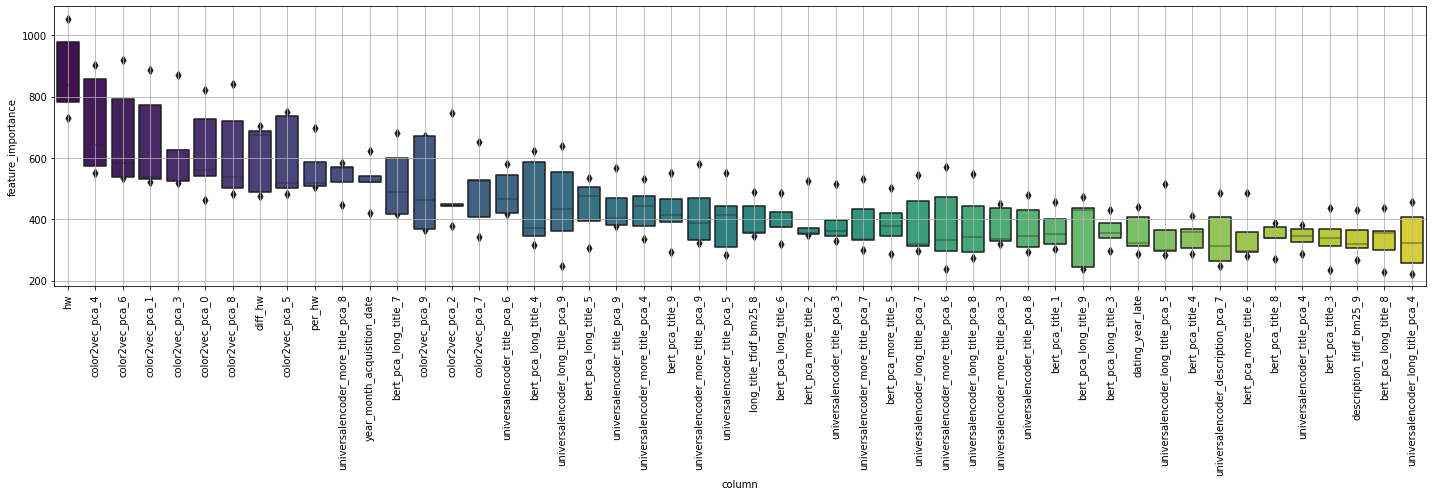

In [7]:
importance = visualize_importance(models_lgbm, train_X)

# XGbosst

In [17]:
import xgboost as xgb

# XGBoost
def fit_xgb(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=100000,
            early_stopping_rounds=verbose,
            evals=evals,
            verbose_eval=verbose)

        pred_i = model.predict(xgb.DMatrix(x_valid))
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

def create_predict_xgb(models, feat_df):
    pred = np.array([model.predict(xgb.DMatrix(feat_df)) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def run_xgb(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_xgb(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_xgb(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

In [18]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'learning_rate':0.01,
    'tree_method':'gpu_hist'}

oof_xgb = np.zeros(train_X.shape[0])
prediction_xgb = np.zeros(test_X.shape[0])

SEEDS = [12] # np.arange(0, 5, 1)
for seed in SEEDS:
    oof_pred, prediction, models_xgb, cv = run_xgb(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=xgb_params,
        verbose=100,
        seed=seed)
    print(cv)

    oof_xgb += oof_pred / len(SEEDS)
    prediction_xgb += prediction / len(SEEDS)

cv = np.sqrt(mean_squared_error(train_y, oof_xgb))
print(f'score:{cv}')

pd.DataFrame(oof_xgb, train.index, columns=['colum2131_model1_pred_xgb']).to_csv(ensumble_dir / f'xgb_train_model1.csv', index=False)
pd.DataFrame(prediction_xgb, test.index, columns=['colum2131_model1_pred_xgb']).to_csv(ensumble_dir / f'xgb_test_model1.csv', index=False)

[0]	train-rmse:2.10703	eval-rmse:2.08033
[100]	train-rmse:1.22791	eval-rmse:1.24996
[200]	train-rmse:0.97454	eval-rmse:1.06735
[300]	train-rmse:0.87145	eval-rmse:1.02343


KeyboardInterrupt: 

# CatBoost

In [19]:
# Catboost
from catboost import CatBoost, Pool

def fit_cat(X, y, params: dict=None, verbose=100, seed=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_pool = Pool(
            x_train,
            label=y_train,
            cat_features=categorycal_list)
        
        valid_pool = Pool(
            x_valid,
            label=y_valid,
            cat_features=categorycal_list)
        
        model = CatBoost(params)
        model.fit(
            train_pool,
            early_stopping_rounds=verbose,
            plot=False,
            use_best_model=True,
            eval_set=[valid_pool],
            verbose=verbose)

        pred_i = model.predict(x_valid)
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

def create_predict_cat(models, feat_df):
    pred = np.array([model.predict(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def run_cat(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_cat(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_cat(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

In [20]:
categorycal_list = []
for i, col in enumerate(train_X.columns):
    if 'label' in col:
        categorycal_list.append(i)
        train_X[col] = train_X[col].astype(object)
        test_X[col] = test_X[col].astype(object)

In [21]:
cat_params = {
    'loss_function': 'RMSE',
    'num_boost_round': 100000,
    'learning_rate': 0.03,
    'random_state': 42,
    'task_type': 'CPU',
    }

oof_cat = np.zeros(train_X.shape[0])
prediction_cat = np.zeros(test_X.shape[0])

SEEDS = [12] # np.arange(0, 5, 1)
for seed in SEEDS:
    oof_pred, prediction, models_cat, cv = run_cat(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=cat_params,
        verbose=100,
        seed=seed)
    print(cv)

    oof_cat += oof_pred / len(SEEDS)
    prediction_cat += prediction / len(SEEDS)

cv = np.sqrt(mean_squared_error(train_y, oof_cat))
print(f'score:{cv}')

pd.DataFrame(oof_cat, train.index, columns=['colum2131_model1_pred_cat']).to_csv(ensumble_dir / f'cat_train_model1.csv', index=False)
pd.DataFrame(prediction_cat, test.index, columns=['colum2131_model1_pred_cat']).to_csv(ensumble_dir / f'cat_test_model1.csv', index=False)

0:	learn: 1.7540764	test: 1.7194711	best: 1.7194711 (0)	total: 104ms	remaining: 2h 54m 2s
100:	learn: 1.1061352	test: 1.0770018	best: 1.0770018 (100)	total: 2.46s	remaining: 40m 32s


KeyboardInterrupt: 